# Exercise 1

### Libraries

In [21]:
import sys
import os
os.environ["CUDA_VISIBLE_DEVICES"] = '0'
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from time import time
import tensorflow as tf
from tensorflow.contrib import learn
from tqdm import trange
from time import time
from Autoencoder.utils import *
import glob as glob
from PIL import Image

### Autoencoder Implementation

In [22]:
class AutoEncoder(object):

  def __init__(self,
               sess,
               inputs,
               targets=None,
               b1=0.5,
               lr=0.1,
               code_size=16,
               batch_size=64,
               n_epoch=1000,
               cost_function='bce',
               name='autoencoder',
               optimizer='adadelta'):
    self.sess = sess  #tensorflow session
    self.b1 = b1  #beta1 for AdadeltaOptimizer
    self.lr = lr  #learning rate
    self.n_epoch = n_epoch  #number of epoch
    self.batch_size = batch_size
    self.inputs = inputs
    self.code_size = code_size  #embedding size
    self.load_dataset()
    if targets is not None:
      self.targets = targets  #for autoencoder, targets is the same to input
      self.gen_noisy_data()
    else:
      self.targets = inputs
    self.cost_function = cost_function
    self.optimizer = optimizer
    self.log = {'train_loss': [], 'valid_loss': []}

    self.name = name

    self.build_model()

  def build_model(self):
    code_size = self.code_size
    with tf.variable_scope(self.name) as scope:
      self.enc1 = tf.layers.dense(
          inputs=self.inputs,
          units=code_size * 16,
          activation=tf.nn.relu,
          name='enc')
      self.enc2 = tf.layers.dense(
          inputs=self.enc1,
          units=code_size * 8,
          activation=tf.nn.relu,
          name='enc2')
      self.enc3 = tf.layers.dense(
          inputs=self.enc2,
          units=code_size * 4,
          activation=tf.nn.relu,
          name='enc3')
      self.code = tf.layers.dense(
          inputs=self.enc3, units=code_size, activation=tf.nn.relu, name='code')

      self.dec1 = tf.layers.dense(
          inputs=self.code,
          units=code_size * 4,
          activation=tf.nn.relu,
          name='dec')
      self.dec2 = tf.layers.dense(
          inputs=self.dec1,
          units=code_size * 8,
          activation=tf.nn.relu,
          name='dec2')
      self.dec3 = tf.layers.dense(
          inputs=self.dec2,
          units=code_size * 16,
          activation=tf.nn.relu,
          name='dec3')
      self.recon_logits = tf.layers.dense(
          inputs=self.dec3, units=28 * 28, name='recon_logits')
      self.jacobian_op = self.jacobian(self.code, self.inputs)
      if self.cost_function == 'mse':
        self.recon = self.recon_logits
        self.cost = tf.reduce_mean(tf.pow(self.targets - self.recon_logits, 2))
      elif self.cost_function == 'bce':
        self.recon = tf.nn.sigmoid(self.recon_logits)
        self.cost = tf.reduce_mean(
            tf.nn.sigmoid_cross_entropy_with_logits(
                labels=self.targets, logits=self.recon_logits))

      else:
        raise NotImplementedError

  def train(self):
    if self.optimizer == 'adadelta':
      self.optim = tf.train.AdadeltaOptimizer(self.lr).minimize(self.cost)
    elif self.optimizer == 'adam':
      self.optim = tf.train.AdamOptimizer(
          self.lr, beta1=self.b1).minimize(self.cost)
    elif self.optimizer == 'rmsprop':
      self.optim = tf.train.RMSPropOptimizer(self.lr).minimize(self.cost)
    else:
      raise NotImplementedError
    init = tf.global_variables_initializer()
    self.sess.run(init)

    X = self.inputs
    t0 = time()
    if self.targets is not self.inputs:
      print('Denoising autoencoder')
      Y = self.targets
      for epoch in trange(self.n_epoch):
        t = time()
        shuffle(self.trX, self.trX_noisy)
        for batch, noisy_batch in iter_data(
            self.trX, self.trX_noisy, size=self.batch_size):
          self.optim.run(
              session=self.sess, feed_dict={X: noisy_batch,
                                            Y: batch})

        idxs = np.random.randint(
            low=0, high=len(self.vaX), size=self.batch_size)
        valid_batch = self.vaX[idxs]
        valid_noisy_batch = self.vaX_noisy[idxs]

        self.log['train_loss'].append(
            self.cost.eval(
                session=self.sess, feed_dict={X: noisy_batch,
                                              Y: batch}))
        self.log['valid_loss'].append(
            self.cost.eval(
                session=self.sess,
                feed_dict={X: valid_noisy_batch,
                           Y: valid_batch}))
      print("final loss %g, total cost time: %.2fs" % (self.cost.eval(
          session=self.sess, feed_dict={X: self.teX_noisy,
                                        Y: self.teX}), time() - t0))

    else:
      print('Audoencoder')
      for epoch in trange(self.n_epoch):
        t = time()
        shuffle(self.trX)
        for batch in iter_data(self.trX, size=self.batch_size):
          self.optim.run(session=self.sess, feed_dict={X: batch})

        idxs = np.random.randint(
            low=0, high=len(self.vaX), size=self.batch_size)
        valid_batch = self.vaX[idxs]

        self.log['train_loss'].append(
            self.cost.eval(session=self.sess, feed_dict={X: batch}))
        self.log['valid_loss'].append(
            self.cost.eval(session=self.sess, feed_dict={X: valid_batch}))
      print("final loss %g, total cost time: %.2fs" %
            (self.cost.eval(session=self.sess, feed_dict={X: self.teX}),
             time() - t0))

  def load_dataset(self):
    #mnist = learn.datasets.load_dataset("mnist")
    #self.trX = mnist.train.images  # Returns np.array
    #self.vaX = mnist.validation.images  # Returns np.array
    #self.teX = mnist.test.images
    filelist = glob.glob('/home/mosquito/Documents/deeplearning/lab15/lab14_utils/horse/*.jpg')
    self.trX = np.array([np.array(Image.open(fname).convert('L').resize((28,28), Image.ANTIALIAS)).flatten()/255 for fname in filelist])
    filelist = glob.glob('/home/mosquito/Documents/deeplearning/lab15/lab14_utils/horse/*.jpg')
    self.vaX = np.array([np.array(Image.open(fname).convert('L').resize((28,28), Image.ANTIALIAS)).flatten()/255 for fname in filelist])
    filelist = glob.glob('/home/mosquito/Documents/deeplearning/lab15/lab14_utils/horse/*.jpg')
    self.teX = np.array([np.array(Image.open(fname).convert('L').resize((28,28), Image.ANTIALIAS)).flatten()/255 for fname in filelist])


  def gen_noisy_data(self):
    # Noise scale
    noise_factor = 0.4
    trX_noisy = self.trX + noise_factor * np.random.normal(
        loc=0., scale=1.0, size=self.trX.shape)
    vaX_noisy = self.vaX + noise_factor * np.random.normal(
        loc=0., scale=1.0, size=self.vaX.shape)
    teX_noisy = self.teX + noise_factor * np.random.normal(
        loc=0., scale=1.0, size=self.teX.shape)

    # Range of our dataset is [0,1]
    self.trX_noisy = np.clip(trX_noisy, 0., 1.)
    self.vaX_noisy = np.clip(vaX_noisy, 0., 1.)
    self.teX_noisy = np.clip(teX_noisy, 0., 1.)

  def encode(self, inputs):

    return self.code.eval(session=self.sess, feed_dict={self.inputs: inputs})

  def reconstruct(self, inputs):
    return self.recon.eval(session=self.sess, feed_dict={self.inputs: inputs})

  def jacobian(self, y, x):
    # For function f: mapping from single column x to multiple values ys
    # Note: tf.gradients returns sum(dy/dx)
    # for each x in xs, so we need to compute each y seperatedly.
    jacobian_flat = tf.concat(
        [tf.gradients(y_i, x)[0] for y_i in tf.unstack(y, axis=1)], axis=0)
    return jacobian_flat

  def get_jaco_matrix(self, xbatch):
    jaco_matrix = []
    for x in xbatch:
      jaco_matrix.append(
          self.jacobian_op.eval(
              session=self.sess, feed_dict={self.inputs: x.reshape(1, -1)})
          .reshape(1, self.code_size, 28 * 28))
    return np.concatenate(jaco_matrix)

### Training

In [23]:
sess = tf.Session()
X = tf.placeholder(tf.float32, shape=[None, 28 * 28])
autoencoder = AutoEncoder(sess=sess, inputs=X, optimizer='adadelta', lr=1)
autoencoder.train()

  1%|          | 6/1000 [00:00<00:17, 57.51it/s]

Audoencoder


100%|██████████| 1000/1000 [00:11<00:00, 84.59it/s]

final loss 0.606155, total cost time: 11.82s


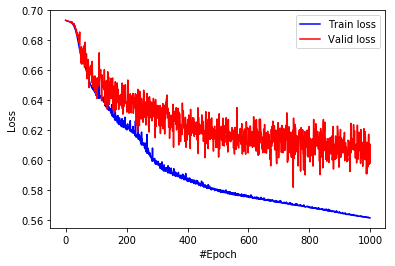

In [24]:
train_loss = autoencoder.log['train_loss']
valid_loss = autoencoder.log['valid_loss']
plt.plot(range(len(train_loss)), train_loss, color='blue', label='Train loss')
plt.plot(range(len(valid_loss)), valid_loss, color='red', label='Valid loss')
plt.legend(loc="upper right")
plt.xlabel('#Epoch')
plt.ylabel('Loss')
plt.show()

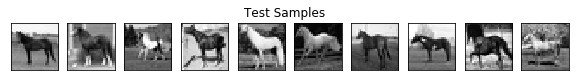

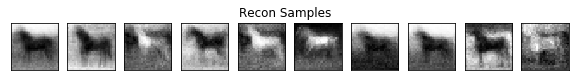

In [25]:
n = 10

orig_imgs = autoencoder.teX[:n].reshape(-1, 28, 28)
recon_imgs = autoencoder.reconstruct(
  orig_imgs.reshape(-1, 28 * 28)).reshape(-1, 28, 28)

plot_imgs(orig_imgs, n=n, title='Test Samples')
plot_imgs(recon_imgs, n=n, title='Recon Samples')

(1, 16, 784)
(16,)


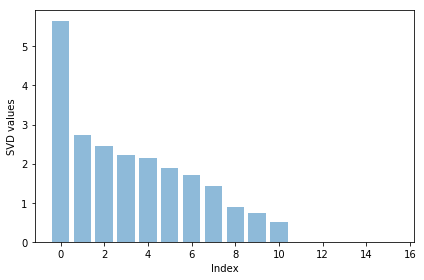

(16, 784)


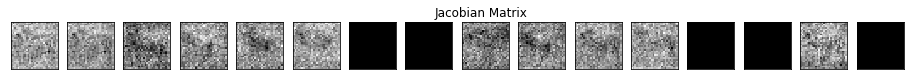

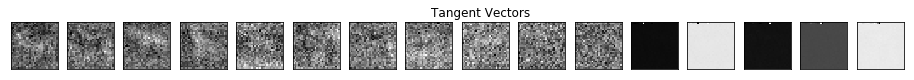

In [26]:
img = autoencoder.teX[:1]
jaco_matrix = autoencoder.get_jaco_matrix(img)
print(jaco_matrix.shape)
V = tangent_vecs(jaco_matrix[0])
print(V.shape)
plot_imgs(jaco_matrix.reshape(-1, 28, 28), n=16, title='Jacobian Matrix')
plot_imgs(V.reshape(-1, 28, 28), n=16, title='Tangent Vectors')

### Denoising

In [27]:
sess.close()
tf.reset_default_graph()
sess = tf.Session()
X = tf.placeholder(tf.float32, shape=[None, 28 * 28])
Y = tf.placeholder(tf.float32, shape=[None, 28 * 28])

# In our AutoEncoder class,
# it will automatically change to denoising autoencoder if "targets" is given.
autoencoder = AutoEncoder(
    sess=sess, inputs=X, targets=Y, optimizer='adadelta', lr=1)
# autoencoderModel = AutoEncoder(
#     sess=sess, inputs=X, optimizer='adam', niter=200, cost_function='mse')
autoencoder.train()

  0%|          | 5/1000 [00:00<00:20, 47.79it/s]

Denoising autoencoder


100%|██████████| 1000/1000 [00:13<00:00, 72.13it/s]

final loss 0.625313, total cost time: 13.87s


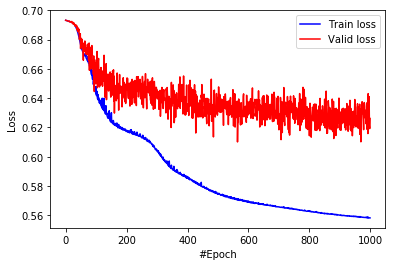

In [28]:
train_loss = autoencoder.log['train_loss']
valid_loss = autoencoder.log['valid_loss']
plt.plot(range(len(train_loss)), train_loss, color='blue', label='Train loss')
plt.plot(range(len(valid_loss)), valid_loss, color='red', label='Valid loss')
plt.legend(loc="upper right")
plt.xlabel('#Epoch')
plt.ylabel('Loss')
plt.show()

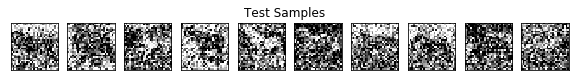

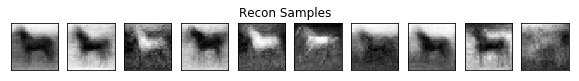

In [29]:
n = 10

orig_imgs = autoencoder.teX_noisy[:n].reshape(-1, 28, 28)
recon_imgs = autoencoder.reconstruct(
  orig_imgs.reshape(-1, 28 * 28)).reshape(-1, 28, 28)

plot_imgs(orig_imgs, n=n, title='Test Samples')
plot_imgs(recon_imgs, n=n, title='Recon Samples')

(16,)


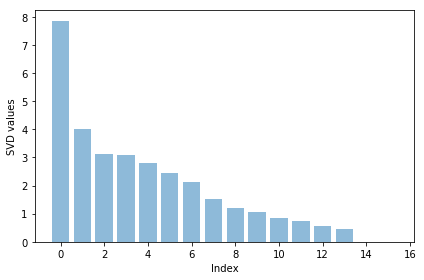

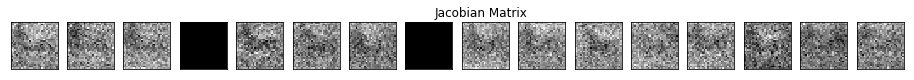

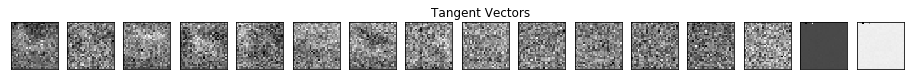

In [30]:
img = autoencoder.teX[:1]
jaco_matrix = autoencoder.get_jaco_matrix(img)
V = tangent_vecs(jaco_matrix[0])
plot_imgs(jaco_matrix.reshape(-1, 28, 28), n=16, title='Jacobian Matrix')
plot_imgs(V.reshape(-1, 28, 28), n=16, title='Tangent Vectors')

#reset the system path
sys.path.pop()

#reset tensorflow graph
tf.reset_default_graph()
sess.close()

# Exercise 2

### Libraries

In [11]:
import sys
sys.path.append('GAN')
from GAN.utils import *
from GAN.ops import *

import os
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import time
import math
from glob import glob
from tensorflow.contrib import learn
import numpy as np
from tqdm import tqdm

### DCGAN Implementation

In [12]:
class DCGAN(object):

  def __init__(self,
               sess,
               input_height=28,
               input_width=28,
               crop=True,
               batch_size=128,
               output_height=28,
               output_width=28,
               y_dim=None,
               z_dim=100,
               gf_dim=64,
               df_dim=64,
               gfc_dim=1024,
               dfc_dim=1024,
               c_dim=1,
               dataset_name='mnist',
               input_fname_pattern='*.jpg',
               checkpoint_dir='checkpoint',
               samples_dir=None,
               show_samples=False,
               learning_rate=2e-4,
               beta1=0.5,
               epoch=100):
    """
    Args:
      sess: TensorFlow session
      batch_size: The size of batch. Should be specified before training.
      y_dim: (optional) Dimension of dim for y. [None]
      z_dim: (optional) Dimension of dim for Z. [100]
      gf_dim: (optional) Dimension of gen filters in first conv layer. [64]
      df_dim: (optional) Dimension of discrim filters in first conv layer. [64]
      gfc_dim: (optional) Dimension of gen units for for fully connected layer. [1024]
      dfc_dim: (optional) Dimension of discrim units for fully connected layer. [1024]
      c_dim: (optional) Dimension of image color. For grayscale input, set to 1. [3]
        """
    self.sess = sess

    self.epoch = epoch
    self.batch_size = batch_size
    self.sample_num = 200
    self.learning_rate = learning_rate
    self.beta1 = beta1

    self.input_height = input_height
    self.input_width = input_width
    self.output_height = output_height
    self.output_width = output_width

    self.y_dim = y_dim
    self.z_dim = z_dim

    self.gf_dim = gf_dim
    self.df_dim = df_dim

    self.gfc_dim = gfc_dim
    self.dfc_dim = dfc_dim

    self.input_fname_pattern = input_fname_pattern
    self.dataset_name = dataset_name
    self.checkpoint_dir = checkpoint_dir
    if not os.path.exists(checkpoint_dir):
      os.makedirs(checkpoint_dir)

    self.samples_dir = samples_dir
    if not os.path.exists(samples_dir) and samples_dir is not None:
      os.makedirs(samples_dir)
    self.show_samples = show_samples

    self.trX, self.teX = self.load_mnist()
    self.ntrain = len(self.trX)
    self.c_dim = 1
    self.grayscale = (self.c_dim == 1)
    self.log = {'d_loss': [], 'g_loss': [], 'gen_samples': []}
    self.build_model()

  def build_model(self):
    image_dims = [self.input_height, self.input_width, self.c_dim]

    self.inputs = tf.placeholder(
        tf.float32, [None] + image_dims, name='real_images')
    self.sample_inputs = tf.placeholder(
        tf.float32, [None] + image_dims, name='sample_inputs')

    inputs = self.inputs
    sample_inputs = self.sample_inputs

    self.z = tf.placeholder(tf.float32, [None, self.z_dim], name='z')

    self.G = self.generator(self.z)
    self.D, self.D_logits_real = self.discriminator(inputs)

    self.D_, self.D_logits_fake = self.discriminator(self.G, reuse=True)

    self.d_loss_real = tf.reduce_mean(
        bce(self.D_logits_real, tf.ones_like(self.D)))
    self.d_loss_fake = tf.reduce_mean(
        bce(self.D_logits_fake, tf.zeros_like(self.D_)))
    self.g_loss = tf.reduce_mean(bce(self.D_logits_fake, tf.ones_like(self.D_)))

    self.d_loss = self.d_loss_real + self.d_loss_fake

    t_vars = tf.trainable_variables()
    # get variables for generator and discriminator,
    # since they are trained separately.
    self.d_vars = [var for var in t_vars if 'd_' in var.name]
    self.g_vars = [var for var in t_vars if 'g_' in var.name]

    self.saver = tf.train.Saver()

  def train(self):
    #get the optimization ops
    d_optim = tf.train.AdamOptimizer(self.learning_rate, beta1=self.beta1) \
              .minimize(self.d_loss, var_list=self.d_vars)
    g_optim = tf.train.AdamOptimizer(self.learning_rate, beta1=self.beta1) \
              .minimize(self.g_loss, var_list=self.g_vars)
    init = tf.global_variables_initializer()
    self.sess.run(init)

    #generate random noise
    sample_z = np.random.uniform(-1, 1, size=(self.sample_num, self.z_dim))
    sample_idxs = np.random.randint(
        low=0, high=len(self.trX), size=self.sample_num)
    sample_inputs = self.trX[sample_idxs]

    counter = 1
    start_time = time.time()
    print('start training')
    for epoch in range(self.epoch):
      shuffle(self.trX)
      for batch_images in iter_data(self.trX, size=self.batch_size):
        batch_z = np.random.uniform(-1, 1, [self.batch_size,
                                            self.z_dim]).astype(np.float32)
        if counter % 2 == 0:
          # Update D network
          self.sess.run(
              d_optim, feed_dict={
                  self.inputs: batch_images,
                  self.z: batch_z,
              })
        else:
          # Update G network
          self.sess.run(
              g_optim, feed_dict={
                  self.z: batch_z,
              })
        counter += 1

      # calculate the loss to monitor the training process
      errD_fake = self.d_loss_fake.eval(
          session=self.sess, feed_dict={self.z: batch_z})
      errD_real = self.d_loss_real.eval(
          session=self.sess, feed_dict={self.inputs: batch_images})
      errG = self.g_loss.eval(session=self.sess, feed_dict={self.z: batch_z})
      self.log['d_loss'].append(errD_fake + errD_real)
      self.log['g_loss'].append(errG)
      print("Epoch: [%2d] time: %.2fs, d_loss: %.4f, g_loss: %.4f" \
        % (epoch,time.time() - start_time, errD_fake+errD_real, errG))

      # save the generated samples
      if (epoch + 1) % 1 == 0:
        samples = self.sess.run(
            self.G, feed_dict={
                self.z: sample_z,
            })
        img = grayscale_grid_vis(
            samples,
            nhw=(10, 20),
            save_path=self.samples_dir + '/%d.jpg' % epoch)
        self.log['gen_samples'].append(img)
        if (epoch + 1) % 10 == 0:
          if self.show_samples:
            plt.imshow(img, cmap='gray')
            plt.axis('off')
            plt.show()

      if (epoch + 1) % 10 == 0:
        self.save(self.checkpoint_dir, counter)

  def discriminator(self, image, y=None, reuse=False):
    with tf.variable_scope("discriminator") as scope:
      if reuse:
        scope.reuse_variables()

      x = image

      h0 = lrelu(conv2d(x, self.c_dim, name='d_h0_conv'))
      h1 = lrelu(bn(conv2d(h0, self.df_dim, name='d_h1_conv')))
      h1 = flatten(h1)
      h2 = lrelu(bn(linear(h1, self.dfc_dim, 'd_h2_lin')))
      h3 = linear(h2, 1, 'd_h3_lin')

      return tf.nn.sigmoid(h3), h3

  def generator(self, z, y=None):
    with tf.variable_scope("generator") as scope:
      s_h, s_w = self.output_height, self.output_width
      s_h2, s_h4 = int(s_h / 2), int(s_h / 4)
      s_w2, s_w4 = int(s_w / 2), int(s_w / 4)

      h0 = tf.nn.relu(bn(linear(z, self.gfc_dim, 'g_h0_lin')))

      h1 = tf.nn.relu(bn(linear(h0, self.gf_dim * 2 * s_h4 * s_w4, 'g_h1_lin')))
      h1 = tf.reshape(h1, [-1, s_h4, s_w4, self.gf_dim * 2])

      h2 = tf.nn.relu(bn(deconv2d(h1, nf=self.gf_dim * 2, name='g_h2')))
      return tf.nn.sigmoid(deconv2d(h2, nf=self.c_dim, name='g_h3'))

  def load_mnist(self):
    mnist = learn.datasets.load_dataset("mnist")
    train_data = mnist.train.images.reshape(-1, 28, 28, 1)  # Returns np.array
    test_data = mnist.test.images.reshape(-1, 28, 28, 1)  # Returns np.array
    return train_data, test_data

  @property
  def model_dir(self):
    return "%s_%s" % (self.dataset_name, self.batch_size)

  def save(self, checkpoint_dir, step):
    model_name = "DCGAN.model"
    checkpoint_dir = os.path.join(checkpoint_dir, self.model_dir)

    if not os.path.exists(checkpoint_dir):
      os.makedirs(checkpoint_dir)

    self.saver.save(
        self.sess, os.path.join(checkpoint_dir, model_name), global_step=step)

  def load(self, checkpoint_dir):
    import re
    print(" [*] Reading checkpoints...")
    checkpoint_dir = os.path.join(checkpoint_dir, self.model_dir)

    ckpt = tf.train.get_checkpoint_state(checkpoint_dir)
    if ckpt and ckpt.model_checkpoint_path:
      ckpt_name = os.path.basename(ckpt.model_checkpoint_path)
      self.saver.restore(self.sess, os.path.join(checkpoint_dir, ckpt_name))
      counter = int(next(re.finditer("(\d+)(?!.*\d)", ckpt_name)).group(0))
      print(" [*] Success to read {}".format(ckpt_name))
      return True, counter
    else:
      print(" [*] Failed to find a checkpoint")
      return False, 0

### WGAN, inherit from DCGAN class

In [13]:
class WGAN(DCGAN):

  def build_model(self):

    # Training critic 5 iterations per generator iteration
    self.n_critic = 5

    image_dims = [self.input_height, self.input_width, self.c_dim]

    self.inputs = tf.placeholder(
        tf.float32, [None] + image_dims, name='real_images')
    self.sample_inputs = tf.placeholder(
        tf.float32, [None] + image_dims, name='sample_inputs')

    inputs = self.inputs
    sample_inputs = self.sample_inputs

    self.z = tf.placeholder(tf.float32, [None, self.z_dim], name='z')

    self.G = self.generator(self.z)
    self.D, self.D_logits_real = self.discriminator(inputs)

    self.D_, self.D_logits_fake = self.discriminator(self.G, reuse=True)

    self.d_loss_real = tf.reduce_mean(self.D_logits_real)
    self.d_loss_fake = tf.reduce_mean(self.D_logits_fake)
    self.g_loss = -tf.reduce_mean(self.D_logits_fake)
    self.d_loss = self.d_loss_fake - self.d_loss_real

    t_vars = tf.trainable_variables()

    self.d_vars = [var for var in t_vars if 'd_' in var.name]
    self.g_vars = [var for var in t_vars if 'g_' in var.name]
    self.saver = tf.train.Saver()

  def train(self):
    g_optim = tf.train.RMSPropOptimizer(learning_rate=5e-5).minimize(
        self.g_loss, var_list=self.g_vars)
    d_optim = tf.train.RMSPropOptimizer(learning_rate=5e-5).minimize(
        self.d_loss, var_list=self.d_vars)

    #get the weight clipping ops
    clip_ops = []
    for var in self.d_vars:
      clip_bounds = [-.01, .01]
      clip_ops.append(
          tf.assign(var, tf.clip_by_value(var, clip_bounds[0], clip_bounds[1])))
    clip_disc_weights = tf.group(*clip_ops)

    init = tf.global_variables_initializer()
    self.sess.run(init)

    sample_z = np.random.uniform(-1, 1, size=(self.sample_num, self.z_dim))
    sample_idxs = np.random.randint(
        low=0, high=len(self.trX), size=self.sample_num)
    sample_inputs = self.trX[sample_idxs]

    counter = 1
    self.n_critic += 1
    start_time = time.time()
    for epoch in range(self.epoch):
      shuffle(self.trX)
      for batch_images in iter_data(self.trX, size=self.batch_size):
        batch_z = np.random.uniform(-1, 1, [self.batch_size,
                                            self.z_dim]).astype(np.float32)
        if counter % self.n_critic:
          # Update D network
          self.sess.run(
              d_optim, feed_dict={
                  self.inputs: batch_images,
                  self.z: batch_z,
              })
          #Apply weight clipping to D network
          self.sess.run(clip_disc_weights)
        else:
          # Update G network
          self.sess.run(
              g_optim, feed_dict={
                  self.z: batch_z,
              })
        counter += 1

      errD_fake = self.d_loss_fake.eval(
          session=self.sess, feed_dict={self.z: batch_z})
      errD_real = self.d_loss_real.eval(
          session=self.sess, feed_dict={self.inputs: batch_images})
      errG = self.g_loss.eval(session=self.sess, feed_dict={self.z: batch_z})
      self.log['d_loss'].append(errD_fake + errD_real)
      self.log['g_loss'].append(errG)
      print("Epoch: [%2d] time: %.2fs, d_loss: %.4f, g_loss: %.4f" \
        % (epoch,time.time() - start_time, errD_fake+errD_real, errG))

      if (epoch + 1) % 1 == 0:
        samples = self.sess.run(
            self.G, feed_dict={
                self.z: sample_z,
            })
        img = grayscale_grid_vis(
            samples,
            nhw=(10, 20),
            save_path=self.samples_dir + '/%d.jpg' % epoch)
        self.log['gen_samples'].append(img)
        if (epoch + 1) % 10 == 0:
          if self.show_samples:
            plt.imshow(img, cmap='gray')
            plt.axis('off')
            plt.show()

      if (epoch + 1) % 10 == 0:
        self.save(self.checkpoint_dir, counter)

### Specifiy model checkpoint directory & samples directory

In [14]:
checkpoint_dir = 'checkpoint'
samples_dir = 'samples'

### Training

Extracting MNIST-data/train-images-idx3-ubyte.gz
Extracting MNIST-data/train-labels-idx1-ubyte.gz
Extracting MNIST-data/t10k-images-idx3-ubyte.gz
Extracting MNIST-data/t10k-labels-idx1-ubyte.gz


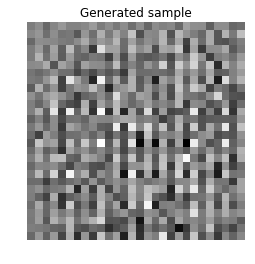

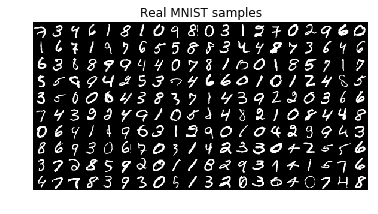

Epoch: [ 0] time: 7.80s, d_loss: 0.7320, g_loss: -0.0726
Epoch: [ 1] time: 15.65s, d_loss: 1.0139, g_loss: -0.0966
Epoch: [ 2] time: 23.74s, d_loss: 1.3543, g_loss: -0.3565
Epoch: [ 3] time: 31.58s, d_loss: 1.2263, g_loss: -0.0976
Epoch: [ 4] time: 39.07s, d_loss: 0.9765, g_loss: -0.1005
Epoch: [ 5] time: 46.43s, d_loss: 1.2612, g_loss: -0.2417
Epoch: [ 6] time: 54.07s, d_loss: 1.3394, g_loss: -0.0704
Epoch: [ 7] time: 61.65s, d_loss: 1.1439, g_loss: -0.0640
Epoch: [ 8] time: 69.25s, d_loss: 1.4405, g_loss: -0.2612
Epoch: [ 9] time: 76.79s, d_loss: 1.3208, g_loss: -0.0653


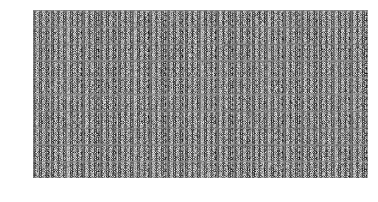

Epoch: [10] time: 84.78s, d_loss: 0.8073, g_loss: -0.0155
Epoch: [11] time: 92.27s, d_loss: 0.9757, g_loss: -0.2409
Epoch: [12] time: 99.86s, d_loss: 1.0362, g_loss: -0.0393
Epoch: [13] time: 107.59s, d_loss: 1.3781, g_loss: -0.0274
Epoch: [14] time: 115.31s, d_loss: 1.3211, g_loss: -0.2334
Epoch: [15] time: 122.92s, d_loss: 1.2502, g_loss: 0.0414
Epoch: [16] time: 130.52s, d_loss: 1.1838, g_loss: 0.0012
Epoch: [17] time: 138.13s, d_loss: 1.5124, g_loss: -0.1864
Epoch: [18] time: 145.73s, d_loss: 1.3066, g_loss: -0.0057
Epoch: [19] time: 153.32s, d_loss: 1.0347, g_loss: -0.0125


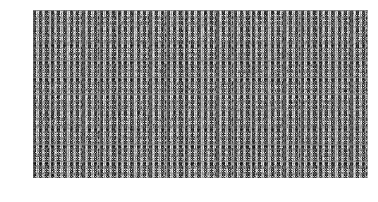

Epoch: [20] time: 161.33s, d_loss: 1.5091, g_loss: -0.1928
Epoch: [21] time: 168.91s, d_loss: 1.3481, g_loss: 0.0290
Epoch: [22] time: 176.51s, d_loss: 1.2219, g_loss: 0.0805
Epoch: [23] time: 184.10s, d_loss: 1.5298, g_loss: -0.2195
Epoch: [24] time: 191.68s, d_loss: 1.0951, g_loss: 0.0721
Epoch: [25] time: 199.28s, d_loss: 1.1026, g_loss: 0.0838
Epoch: [26] time: 206.86s, d_loss: 1.4938, g_loss: -0.1489
Epoch: [27] time: 214.45s, d_loss: 1.0626, g_loss: 0.1279
Epoch: [28] time: 222.04s, d_loss: 1.2732, g_loss: 0.0374
Epoch: [29] time: 229.62s, d_loss: 1.4911, g_loss: -0.0890


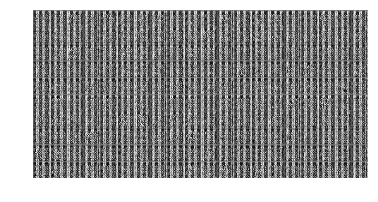

Epoch: [30] time: 237.53s, d_loss: 0.5167, g_loss: 0.0858
Epoch: [31] time: 245.12s, d_loss: 1.0826, g_loss: 0.1095
Epoch: [32] time: 252.88s, d_loss: 1.4689, g_loss: -0.1791
Epoch: [33] time: 260.47s, d_loss: 1.0485, g_loss: 0.0443
Epoch: [34] time: 268.05s, d_loss: 1.4415, g_loss: 0.0209
Epoch: [35] time: 275.65s, d_loss: 1.5947, g_loss: -0.1902
Epoch: [36] time: 283.23s, d_loss: 1.3081, g_loss: 0.0654
Epoch: [37] time: 290.81s, d_loss: 1.1606, g_loss: 0.0948
Epoch: [38] time: 298.41s, d_loss: 1.3209, g_loss: -0.0656
Epoch: [39] time: 305.98s, d_loss: 1.2498, g_loss: 0.1639


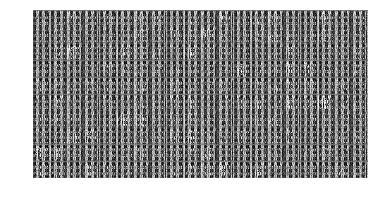

Epoch: [40] time: 313.79s, d_loss: 1.1343, g_loss: 0.0967
Epoch: [41] time: 321.41s, d_loss: 1.1024, g_loss: 0.0573
Epoch: [42] time: 329.02s, d_loss: 1.2668, g_loss: 0.0801
Epoch: [43] time: 336.61s, d_loss: 1.1835, g_loss: 0.0791
Epoch: [44] time: 344.20s, d_loss: 1.3091, g_loss: -0.0259
Epoch: [45] time: 351.76s, d_loss: 1.2243, g_loss: 0.1033
Epoch: [46] time: 359.36s, d_loss: 1.0854, g_loss: 0.1498
Epoch: [47] time: 366.93s, d_loss: 1.3549, g_loss: -0.0198
Epoch: [48] time: 374.51s, d_loss: 0.8259, g_loss: 0.2032
Epoch: [49] time: 382.10s, d_loss: 1.0177, g_loss: 0.2754


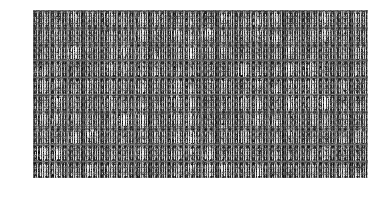

Epoch: [50] time: 389.91s, d_loss: 1.1349, g_loss: 0.0298
Epoch: [51] time: 397.53s, d_loss: 1.0469, g_loss: 0.1427
Epoch: [52] time: 405.14s, d_loss: 1.0873, g_loss: 0.1321
Epoch: [53] time: 412.72s, d_loss: 1.3989, g_loss: -0.0564
Epoch: [54] time: 420.32s, d_loss: 0.9091, g_loss: 0.0219
Epoch: [55] time: 427.95s, d_loss: 0.7560, g_loss: 0.0711
Epoch: [56] time: 435.67s, d_loss: 1.2997, g_loss: -0.0567
Epoch: [57] time: 443.26s, d_loss: 1.1515, g_loss: 0.1265
Epoch: [58] time: 450.85s, d_loss: 1.0360, g_loss: 0.1396
Epoch: [59] time: 458.44s, d_loss: 0.7289, g_loss: -0.0809


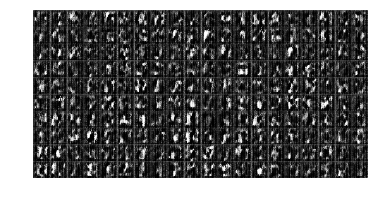

Epoch: [60] time: 466.28s, d_loss: 0.8829, g_loss: 0.0665
Epoch: [61] time: 473.86s, d_loss: 1.0280, g_loss: 0.1191
Epoch: [62] time: 481.45s, d_loss: 0.9622, g_loss: -0.0481
Epoch: [63] time: 489.03s, d_loss: 1.0183, g_loss: 0.0868
Epoch: [64] time: 496.59s, d_loss: 0.9106, g_loss: 0.0721
Epoch: [65] time: 504.17s, d_loss: 1.0601, g_loss: -0.0498
Epoch: [66] time: 511.73s, d_loss: 0.6688, g_loss: 0.0715
Epoch: [67] time: 519.33s, d_loss: 0.9164, g_loss: 0.0816
Epoch: [68] time: 527.49s, d_loss: 1.0413, g_loss: -0.0743
Epoch: [69] time: 535.17s, d_loss: 0.8196, g_loss: 0.1357


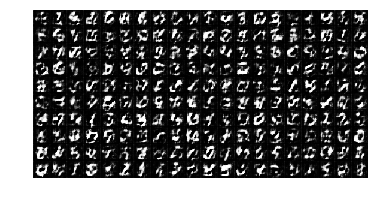

Epoch: [70] time: 543.10s, d_loss: 0.8746, g_loss: 0.1254
Epoch: [71] time: 550.65s, d_loss: 1.0651, g_loss: -0.1116
Epoch: [72] time: 558.18s, d_loss: 0.7388, g_loss: 0.1120
Epoch: [73] time: 565.83s, d_loss: 0.6634, g_loss: 0.2245
Epoch: [74] time: 573.49s, d_loss: 1.0795, g_loss: -0.0900
Epoch: [75] time: 581.09s, d_loss: 0.8533, g_loss: 0.1575
Epoch: [76] time: 588.66s, d_loss: 0.7436, g_loss: 0.1129
Epoch: [77] time: 596.22s, d_loss: 0.6682, g_loss: -0.0140
Epoch: [78] time: 603.87s, d_loss: 0.7467, g_loss: 0.1515
Epoch: [79] time: 611.45s, d_loss: 0.8451, g_loss: 0.0577


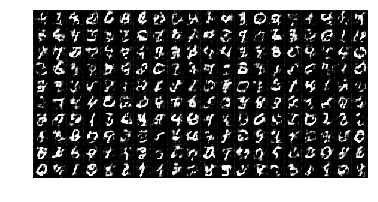

Epoch: [80] time: 619.24s, d_loss: 0.8408, g_loss: -0.1066
Epoch: [81] time: 626.80s, d_loss: 0.6099, g_loss: 0.0876
Epoch: [82] time: 634.35s, d_loss: 0.5640, g_loss: 0.1860
Epoch: [83] time: 641.97s, d_loss: 1.0324, g_loss: -0.1335
Epoch: [84] time: 649.50s, d_loss: 0.6006, g_loss: 0.2123
Epoch: [85] time: 657.28s, d_loss: 0.8465, g_loss: 0.0831
Epoch: [86] time: 664.87s, d_loss: 0.7335, g_loss: -0.1368
Epoch: [87] time: 672.52s, d_loss: 0.9993, g_loss: -0.0627
Epoch: [88] time: 680.13s, d_loss: 0.5810, g_loss: 0.2086
Epoch: [89] time: 687.86s, d_loss: 0.8382, g_loss: -0.1488


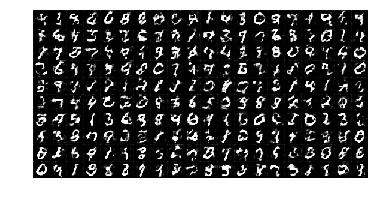

Epoch: [90] time: 695.73s, d_loss: 0.6818, g_loss: 0.0589
Epoch: [91] time: 702.97s, d_loss: 0.6681, g_loss: 0.0764
Epoch: [92] time: 710.42s, d_loss: 0.9912, g_loss: -0.2625
Epoch: [93] time: 717.71s, d_loss: 0.7952, g_loss: 0.0321
Epoch: [94] time: 725.05s, d_loss: 0.8857, g_loss: -0.0010
Epoch: [95] time: 732.74s, d_loss: 0.7475, g_loss: -0.0931
Epoch: [96] time: 740.60s, d_loss: 0.6548, g_loss: 0.0790
Epoch: [97] time: 748.31s, d_loss: 0.5757, g_loss: 0.1096
Epoch: [98] time: 755.72s, d_loss: 0.6431, g_loss: -0.0937
Epoch: [99] time: 763.43s, d_loss: 0.7836, g_loss: 0.0143


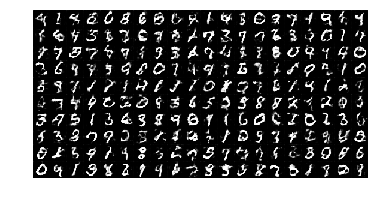

In [15]:
sess = tf.Session()
model = WGAN(
    sess,
    input_width=28,
    input_height=28,
    output_width=28,
    output_height=28,
    batch_size=128,
    input_fname_pattern='*.jpg',
    checkpoint_dir=checkpoint_dir,
    samples_dir=samples_dir,
    show_samples=True,
    epoch=100)

# show_all_variables()
init = tf.global_variables_initializer()
sess.run(init)
sample_z = np.random.uniform(-1, 1, size=(200, 100))
samples = model.G.eval(session=model.sess, feed_dict={model.z: sample_z})
plt.imshow(samples[0].reshape(28, 28), cmap='gray')
plt.axis('off')
plt.title('Generated sample')
plt.show()

samples = model.trX[:200]
img = grayscale_grid_vis(samples, nhw=(10, 20))
plt.imshow(img, cmap='gray')
plt.axis('off')
plt.title('Real MNIST samples')
plt.show()

model.train()

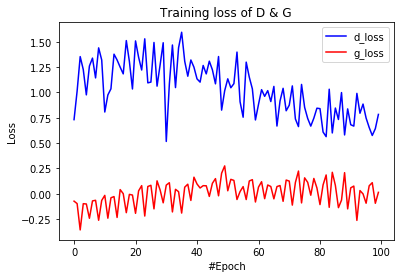

In [16]:
d_loss = model.log['d_loss']
g_loss = model.log['g_loss']
plt.plot(range(len(d_loss)), d_loss, color='blue', label='d_loss')
plt.plot(range(len(g_loss)), g_loss, color='red', label='g_loss')
plt.legend(loc="upper right")
plt.xlabel('#Epoch')
plt.ylabel('Loss')
plt.title('Training loss of D & G')
plt.show()

In [19]:
imgs = np.array(model.log['gen_samples'])
make_gif(imgs * 255., 'GAN/mnist_105062620.gif', true_image=True, duration=2)

from IPython.display import Image
Image(url='GAN/mnist_105062620.gif')


[MoviePy] Building file GAN/mnist_105062620.gif with imageio


 99%|█████████▉| 100/101 [00:01<00:00, 57.82it/s]


In [18]:
tf.reset_default_graph()
sess.close()